# Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import zipfile
import _pickle
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score
import time
import os

from ourfunctions_v3 import clean_nan_samples, try_clf, apply_feature_selection

In [4]:
m = 2000; M = 12000; 
bin_size = 5;

path = "D:/GitHub/Machine-Learning/Kaggle/"
# path = "C:/Users/Javi/Documents/GitHub/Machine-Learning/Kaggle/"

# # Take the data from Google Drive
# from google.colab import drive
# drive.mount('/content/drive',force_remount=True)
# path = "/content/drive/My Drive/Colab Notebooks/Kaggle/"

In [5]:
savepath = path + 'Kaggle classifiers/bin size 5/'
path_results = path + 'Kaggle_results/'

ncpu = os.cpu_count()
if (ncpu>2): njobs = ncpu - 2; 
else: njobs = 1;

In [65]:
zf = zipfile.ZipFile(path+'zipped_TrainData.zip', 'r')
df_train = _pickle.loads(zf.open('TrainData.pkl').read())
zf.close()

zf = zipfile.ZipFile(path+'zipped_TestDataUnlabeled.zip', 'r')
df_test = _pickle.loads(zf.open('TestDataUnlabeled.pkl').read())
zf.close()

In [68]:
def remove_noise(df):
    N = len(df)  # number of samples
    idx_list = []
    for idx in range(N): 
        intensity = df[['intensity']].iloc[idx].values[0]
        mzcoord   = df[['coord_mz']].iloc[idx].values[0]

        if np.var(intensity) < 100:
          idx_list.append(idx)
          print('Training sample', idx, ' eliminated')
    new_df = df.drop(index = idx_list)
#     new_df = new_df.fillna(0)
    return new_df

In [67]:
df_train = remove_noise(df_train)

Training sample 339  eliminated
Training sample 490  eliminated
RangeIndex(start=0, stop=516, step=1, name='ID')


In [9]:
def spectrum_in_bins_2(df, m, M, bin_size): # new version
    # Now, let's define the mz ranges, and the label associated to each of them (the mean of the limiting values of each bin)
    range_min = []; range_max = []; range_mean = [];
    for mz in range(m,M,bin_size):
        range_min.append(mz)
        range_max.append(mz+bin_size)
        range_mean.append(np.mean([range_min[-1],range_max[-1]]).astype(int))
    N = len(df)  # number of samples
    L = len(range_min)  # length of new spectrum (number of bins)
    all_data = np.zeros((N,L))
    for idx in range(N): 
        intensity = df[['intensity']].iloc[idx].values[0]
        mzcoord   = df[['coord_mz']].iloc[idx].values[0]
        idx_data_in_bins = np.zeros((1,L))
        for i,mz in enumerate(range_min):
            intensity_range = intensity[(mzcoord > mz) & (mzcoord < (mz+bin_size))]
            if len(intensity_range) > 0 :
                # as we are interested in peak values, let's keep the maximum value in the interval
                idx_data_in_bins[0,i] = np.max(intensity_range)
            else: # if those mz coordinates are not in that spectrum we interpolate
                idx_data_in_bins[0,i] = np.interp(x=range_mean[i],xp=mzcoord,fp=intensity)  

        # Normalize the amplitude of the spectrum
        idx_data_in_bins[0,:] = idx_data_in_bins[0,:] / np.max(idx_data_in_bins[0,:])
        all_data[idx,:] = idx_data_in_bins
    new_df = pd.DataFrame(data=all_data, columns = range_mean, index = df.index)
    return new_df

### Testing interpolation of the full spectrum
It is easy to find out that the finer we take the interpolation, the more accurate it will be. For a bin_size=1, interpolation works very well. For bin_size 5 or 20, it is coarser and the amplitude of many peaks is likely to be lost.

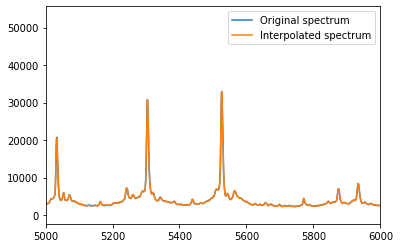

In [35]:
# let's test interpolation
m = 0; M = 20000; 
bin_size = 1;

plt.figure()
idx = 3
intensity = df_train[['intensity']].iloc[idx].values[0]
mzcoord   = df_train[['coord_mz']].iloc[idx].values[0]
plt.plot(mzcoord,intensity,label='Original spectrum')

range_min = []; range_max = []; range_mean = [];
for mz in range(m,M,bin_size):
    range_min.append(mz)
    range_max.append(mz+bin_size)
    range_mean.append(np.mean([range_min[-1],range_max[-1]]).astype(int))
    
interpolated_spectrum = np.interp(x=range_mean,xp=mzcoord,fp=intensity)
plt.plot(range_mean,interpolated_spectrum,label='Interpolated spectrum')
plt.legend()
plt.xlim(5000,6000)
plt.show()

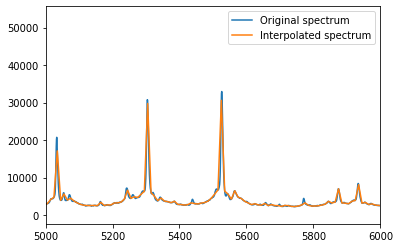

In [36]:
# let's test interpolation
m = 0; M = 20000; 
bin_size = 10;

plt.figure()
idx = 3
intensity = df_train[['intensity']].iloc[idx].values[0]
mzcoord   = df_train[['coord_mz']].iloc[idx].values[0]
plt.plot(mzcoord,intensity,label='Original spectrum')

range_min = []; range_max = []; range_mean = [];
for mz in range(m,M,bin_size):
    range_min.append(mz)
    range_max.append(mz+bin_size)
    range_mean.append(np.mean([range_min[-1],range_max[-1]]).astype(int))
    
interpolated_spectrum = np.interp(x=range_mean,xp=mzcoord,fp=intensity)
plt.plot(range_mean,interpolated_spectrum,label='Interpolated spectrum')
plt.legend()
plt.xlim(5000,6000)
plt.show()

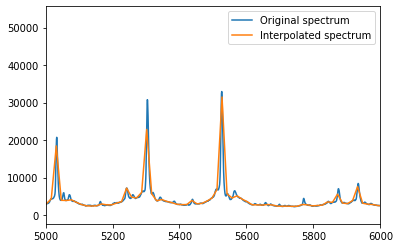

In [37]:
# let's test interpolation
m = 0; M = 20000; 
bin_size = 15;

plt.figure()
idx = 3
intensity = df_train[['intensity']].iloc[idx].values[0]
mzcoord   = df_train[['coord_mz']].iloc[idx].values[0]
plt.plot(mzcoord,intensity,label='Original spectrum')

range_min = []; range_max = []; range_mean = [];
for mz in range(m,M,bin_size):
    range_min.append(mz)
    range_max.append(mz+bin_size)
    range_mean.append(np.mean([range_min[-1],range_max[-1]]).astype(int))
    
interpolated_spectrum = np.interp(x=range_mean,xp=mzcoord,fp=intensity)
plt.plot(range_mean,interpolated_spectrum,label='Interpolated spectrum')
plt.legend()
plt.xlim(5000,6000)
plt.show()

### Short spectra
Most spectra have around 20.000 data points. However, some have only around 4.000 and this is probably reducing the accuracy of our prediction (as before we were placing a 0 in bins where there were no values).

<class 'numpy.ndarray'>
(20000,)


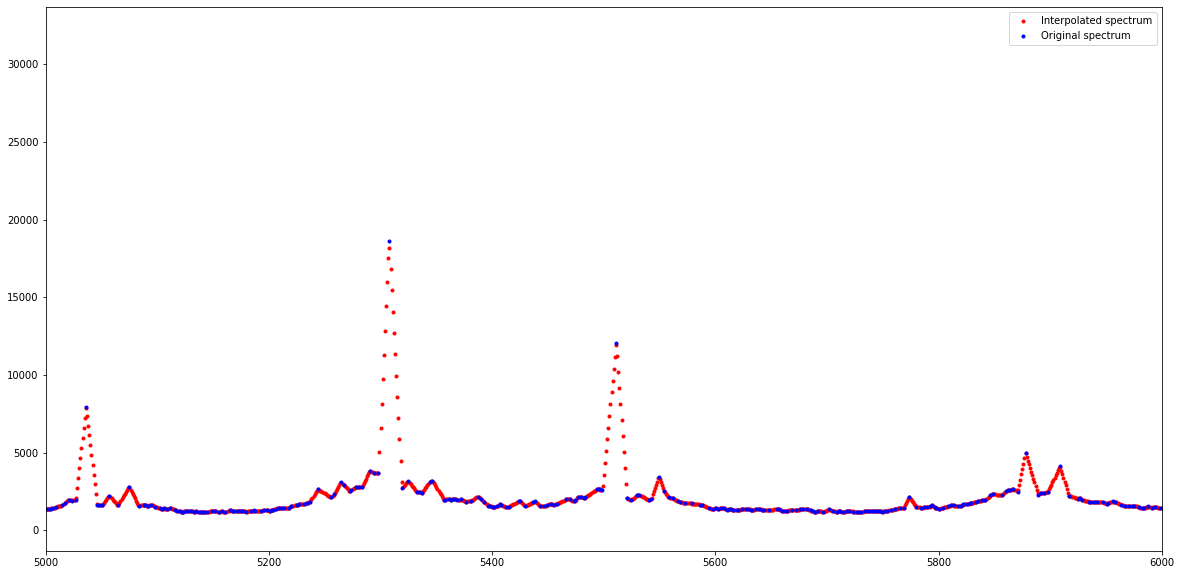

In [40]:
# let's test interpolation
m = 0; M = 20000; 
bin_size = 1;

plt.figure(figsize=(20,10))
idx = 508
intensity = df_train[['intensity']].iloc[idx].values[0]
mzcoord   = df_train[['coord_mz']].iloc[idx].values[0]

range_min = []; range_max = []; range_mean = [];
for mz in range(m,M,bin_size):
    range_min.append(mz)
    range_max.append(mz+bin_size)
    range_mean.append(np.mean([range_min[-1],range_max[-1]]).astype(int))
    
interpolated_spectrum = np.interp(x=range_mean,xp=mzcoord,fp=intensity)
print(type(interpolated_spectrum))
print(interpolated_spectrum.shape)
plt.plot(range_mean,interpolated_spectrum,'r.',label='Interpolated spectrum')
plt.plot(mzcoord,intensity,'b.',label='Original spectrum')
plt.legend()
plt.xlim(5000,6000)
plt.show()

We can see how interpolation improves over this problem, creating a softer and clearer spectrum. Therefore, in order to regularize the spectra, we can just apply this function with a bin_size of 1, and interpolate to a regular MZ axis. So let's create a function that just does this.

## Interpolation
There are two options:
* interpolate_spectra just interpolates the full spectra. It is very accurate for small step_size (eg 1), but it generates a huge number of "features". This should be fine as long as later we perform feature selection in order to only choose a few values.
* spectrum_in_bin_2 is another option. It works as previous, but in case there is no data points in that bin, it uses interpolation. It generates less features, and more importantly, it may be able to put in the same bin the same peak at slightly different coordinates.

In [75]:
def interpolate_spectra(df, m, M, step_size):
    # step_size is the size of each step; 1 interpolates very well.
    mz_range = np.arange(m,M+1,step_size)
    
    N = len(df)  # number of samples
    L = len(mz_range)  # length of new spectrum (number of bins)
    all_data = np.zeros((N,L))
    idx_list = []
    
    for idx in range(N): 
        intensity = df[['intensity']].iloc[idx].values[0]       
        mzcoord   = df[['coord_mz']].iloc[idx].values[0]
        interpolated_spectrum = np.interp(x=mz_range,xp=mzcoord,fp=intensity)
        interpolated_spectrum = interpolated_spectrum / np.max(interpolated_spectrum)
        all_data[idx,:] = interpolated_spectrum
    new_df = pd.DataFrame(data=all_data, columns = mz_range, index = df.index)
    return new_df

def spectrum_in_bins_2(df, m, M, bin_size): # new version
    # Now, let's define the mz ranges, and the label associated to each of them (the mean of the limiting values of each bin)
    range_min = []; range_max = []; range_mean = [];
    for mz in range(m,M,bin_size):
        range_min.append(mz)
        range_max.append(mz+bin_size)
        range_mean.append(np.mean([range_min[-1],range_max[-1]]).astype(int))
    N = len(df)  # number of samples
    L = len(range_min)  # length of new spectrum (number of bins)
    all_data = np.zeros((N,L))
    for idx in range(N): 
        intensity = df[['intensity']].iloc[idx].values[0]
        mzcoord   = df[['coord_mz']].iloc[idx].values[0]
        idx_data_in_bins = np.zeros((1,L))
        for i,mz in enumerate(range_min):
            intensity_range = intensity[(mzcoord > mz) & (mzcoord < (mz+bin_size))]
            if len(intensity_range) > 0 :
                # as we are interested in peak values, let's keep the maximum value in the interval
                idx_data_in_bins[0,i] = np.max(intensity_range)
            else: # if those mz coordinates are not in that spectrum we interpolate
                idx_data_in_bins[0,i] = np.interp(x=range_mean[i],xp=mzcoord,fp=intensity)  

        # Normalize the amplitude of the spectrum
        idx_data_in_bins[0,:] = idx_data_in_bins[0,:] / np.max(idx_data_in_bins[0,:])
        all_data[idx,:] = idx_data_in_bins
    new_df = pd.DataFrame(data=all_data, columns = range_mean, index = df.index)
    return new_df

In [76]:
# df_train = df_train.drop_duplicates(subset='ID_sample') # eliminate duplicates
# Let's work without duplicates from now on, to avoid having same sample in training and test_training sets

# Extract data (spectra) and targets of the df_train set
data = df_train.iloc[:,-2:]
targets = df_train.iloc[:,1:-2]

# Then, split into a train and test_train set
data_train, data_test_train, targets_train, targets_test_train = train_test_split(data, targets, test_size=0.3, random_state=0) # split the data
print('Training samples: '+str(len(data_train))+' and test_train samples: ' + str(len(data_test_train)) )

step_size = 1
# apply the bins to all spectra, so that our feature space becomes the same for all samples (make them regular, all the same)
spectrum_train = interpolate_spectra(data_train,m,M,step_size)
spectrum_test_train = interpolate_spectra(data_test_train,m,M,step_size)
print('Spectrum interpolated!')
# these spectrum_... are our X for training

Training samples: 359 and test_train samples: 155
Spectrum interpolated!
